# Single Particle Model (SPM): Fast discharge

In [1]:
# need to restart jupyter server? kernal? whenever a change is made to the pybamm module? 
import sys
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm
print(pybamm.__path__[0])
import dfols
from scipy import integrate


%matplotlib widget
# pybamm.set_logging_level("INFO")

c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


# Load current data from ESC experiment

In [2]:
# import drive cycle from file
data = pd.read_csv("./fast_discharge/ESC_75SOC_full.csv")
drive_cycle_current = data[['Time (s)', 'Current Shunt']].to_numpy()
drive_cycle_current[:,1] = -data['Current Shunt']
print([key for key in data.keys()])
data.head()


['Time (s)', 'Voltage (V)', 'Current (A)', 'Cell Temperature', 'Thermocouple_2', 'Force', 'Current Shunt', 'CO2 from CAN (ppm)', 'Humidity', 'Pressure', 'Status 1 ', 'Gas Temperature', 'Status 2', 'Thermal Conductivity', 'Temperature_T_type']


,Time (s),Voltage (V),Current (A),Cell Temperature,Thermocouple_2,Force,Current Shunt,CO2 from CAN (ppm),Humidity,Pressure,Status 1,Gas Temperature,Status 2,Thermal Conductivity,Temperature_T_type
0,0.223,0.0,0,0.0,0.0,0.0,0.0,465,28.4,100.0,0,23.40625,0,0.977,0.0
1,0.973,0.0,0,0.0,0.0,0.0,0.0,465,28.4,100.0,0,23.40625,0,0.977,0.0
2,1.083,0.0,0,0.0,0.0,0.0,0.0,465,28.4,100.0,0,23.40625,0,0.977,0.0
3,1.193,0.0,0,0.0,0.0,0.0,0.0,465,28.4,100.0,0,23.40625,0,0.977,0.0
4,1.303,0.0,0,0.0,0.0,0.0,0.0,465,28.4,100.0,0,23.40625,0,0.977,0.0


# Set up simulation

In [3]:
class ExternalCircuitResistanceFunction():
    def __call__(self, variables):
        I = variables["Current [A]"]
        V = variables["Terminal voltage [V]"]
        R_ext = pybamm.FunctionParameter("External resistance [Ohm]",  {"Time [s]": pybamm.t}) 
        R_tab = pybamm.FunctionParameter("Tabbing resistance [Ohm]",  {"Time [s]": pybamm.t})
        return V/I - (R_ext + R_tab)

In [4]:
from pybamm import exp, constants, Parameter


def modified_graphite_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Negative electrode diffusion coefficient [m2.s-1]")
    # D_ref = 16*5.0 * 10 ** (-15)
    E_D_s = 42770/10
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    # soc = (sto - 0.036)/(0.842-0.036)
    soc = (sto - 0)/(0.8321-0)


    # k = -11.79206386*soc**3 + 19.74642427*soc**2 -9.58613417*soc + 2.18105841 #fitted without thermal model
    # k = 0.86610992*soc + 0.15162466 #11?
    k = 0.95*soc + 0.05 #

    # p_high = -15.88891693*soc**3 + 32.73897665*soc**2 -22.08987841*soc + 5.8916456 # high SOC
    # p_low = 15.47540036*soc**2 -10.8508352*soc + 2.13736774 # low SOC
    # k = p_high*(1/(1 + exp(-(soc-0.4)*150)))+ p_low*(1-1/(1 + exp(((0.4-soc)*150))))

    # Ds11
    # p_high = 1.3792875#-15.85192692*soc**3 + 34.1354626*soc**2 -23.71872136*soc + 6.33107728 # high SOC
    # p_low = 0.23807837 #0.35006582 # low SOC
    # # p_high = -0.9128685*soc + 1.95773523
    # # p_low = -1.40355492 + 0.68102741
    # k = p_high*(1/(1 + exp(-(soc-0.4)*20)))+ p_low*(1-1/(1 + exp(((0.4-soc)*20))))

    return D_ref*k # *(-0.9 * sto + 1)

def modified_NMC_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Positive electrode diffusion coefficient [m2.s-1]")
    E_D_s = 18550/10
    soc = (0.837-sto)/(0.837-0.034)
    k = 3.77967906*soc**2 - 3.54525492*soc + 1.04220164 # 8 fitted with thermal model 
    # k = 3.73478491*soc**2 - 3.50522373*soc + 1.03247363 # 8?fitted without thermal model

    # k = 1.73857835*soc**2 -0.95867106*soc + 0.29889581 # 9 removing high error fits. fitted without thermal model
    # k =  3.32316507*soc**2 -3.06075959*soc + 0.94787949 # 11 removing high error fits k0=[SOC_0]*2
    # k = 0.62889645*soc +0.08790276

    # p_high = -7.54090264*soc**3 +17.18863735*soc**2 -10.57421123*soc + 1.97512672 # high SOC
    # p_low = 6.12915318*soc**2 -4.58479402*soc + 1.06832757# low SOC
    # k = p_high*(1/(1 + exp(-(soc-0.6)*150)))+ p_low*(1-1/(1 + exp(((0.6-soc)*150))))
    # arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
    
    return D_ref *k

def modified_electrolyte_diffusivity_PeymanMPM(c_e, T):
    # D_c_e = 5.35 * 10 ** (-10)
    D_c_e =  Parameter("Typical electrolyte diffusivity [m2.s-1]")
    E_D_e = 37040
    arrhenius = exp(E_D_e / constants.R * (1 / 298.15 - 1 / T))
    # k = Parameter("Electrolyte diffusion scalar")
    # k_T =  1/(1 + exp(-10*((114+273.15)-T))*(1-0.5)+0.5)
    # k_T=1
    # D_c_e = 8.794e-11 * (c_e/ 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    # k_T =  pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    return D_c_e#*arrhenius

def modified_electrolyte_conductivity_PeymanMPM(c_e, T):
    # sigma_e = 1.3
    sigma_e = Parameter("Typical electrolyte conductivity [m2.s-1]")
    E_k_e = 34700
    arrhenius = exp(E_k_e / constants.R * (1 / 298.15 - 1 / T))

    # k_T = 1*(1/(1 + exp(-(T-(114+273.15))*150)))+ 1*(1-1/(1 + exp(((114+273.15)-T)*150)))
    # k_T =  1#pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    # k_T =  1/(1 + exp(-5*((114+273.15)-T))*(1-0.9)+0.9)
    return sigma_e#*k_T# (1-k)#*arrhenius

In [5]:
solutions = []
SOC_0 = [0.75]#, 0.15]
SOC_name = [0.75]
Q_nom = 4.5
h = 1.5
Cp = 1.75
R_tab = pybamm.Parameter("Tabbing resistance [Ohm]")
R_ext = pybamm.Parameter("External resistance [Ohm]")
data_sets = []
R_tab_list =  [0.0078, 0.007]#, 0.015] # 0.0085 (100%)
for j, soc in enumerate(SOC_0):

    # load data import ESC data from file
    raw_data = pd.read_csv("./fast_discharge/ESC_"+  str(int(SOC_name[j]*100)) + "SOC_full.csv")
    esc_start = raw_data[-raw_data['Current Shunt']>1].index[0]-1
    esc_end = raw_data[raw_data['Time (s)']>15*60].index[0]
    T_amb = np.mean(raw_data['Cell Temperature'][(raw_data.index < esc_start) & (raw_data['Cell Temperature'] >0)])
    data = raw_data[['Time (s)', 'Voltage (V)', 'Cell Temperature', 'Current Shunt', 'Force']].loc[esc_start:esc_end].copy()
    data['Current Shunt'] = -data['Current Shunt']
    data['Time (s)'] = data['Time (s)'] - data['Time (s)'].loc[esc_start]
    df_labels = ['t', 'V', 'Temp','I', 'F']
    data.set_axis(df_labels, axis=1, inplace=True)
    data['I_C'] = data.I/Q_nom 
    AhT_calculated = integrate.cumtrapz(abs(data.I), data.t-data.t.iloc[0])/3600
    AhT_calculated = np.append(AhT_calculated,AhT_calculated[-1])
    data['SOC'] = soc - AhT_calculated/Q_nom 
    data_sets.append(data)

    options = {
        "thermal": "x-lumped",
#         "side reactions": "decomposition", 
        "operating mode": ExternalCircuitResistanceFunction(),
    }
    model = pybamm.lithium_ion.SPMe(options = options)
    chemistry = pybamm.parameter_sets.Mohtat2020
    # chemistry["electrolyte"] = "lipf6_Nyman2008"
    # chemistry["electrolyte"] = "LiPF6_Mohtat2020"
    param = pybamm.ParameterValues(chemistry)
    
    param.update({
        "Tabbing resistance [Ohm]":  R_tab_list[j],#0.0041,D
        "External resistance [Ohm]": 0.0067, # 0.0067
        "Cell capacity [A.h]": 4.6, #nominal
        "Typical current [A]": 4.6,
        "Negative electrode thickness [m]":62E-06*4.2/5,
        "Positive electrode thickness [m]":67E-06*4.2/5,
        "Lower voltage cut-off [V]": 0,
        "Ambient temperature [K]":T_amb + 273.15,
        "Initial temperature [K]": 296.7,
        "Negative tab width [m]":2.5e-2,
        "Positive tab width [m]":2.5e-2,
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Edge heat transfer coefficient [W.m-2.K-1]":h,
        "Total heat transfer coefficient [W.m-2.K-1]":h,
        "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
        "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM,
        "Electrolyte diffusivity [m2.s-1]": modified_electrolyte_diffusivity_PeymanMPM,
        "Electrolyte conductivity [S.m-1]": modified_electrolyte_conductivity_PeymanMPM,
        # "Diffusion stoichiometry scalar": 2,
        # "Diffusion stoichiometry offset": 1,
        # "Electrolyte diffusion scalar":100,
    }, check_already_exists = False)

    V = model.variables["Terminal voltage [V]"]
    I = model.variables["Current [A]"]
    model.variables.update({
        "Terminal voltage [V]": V - I*R_tab,
        "Actual resistance [Ohm]":V/I,
        }
    )
    
    dt = 0.1
    t_eval = np.arange(0, 8*60, dt)
    solver = pybamm.CasadiSolver(mode="safe") #dt_max = 1e-3, extra_options_setup={"max_num_steps": 10000}
    sim = pybamm.Simulation(model, parameter_values = param, solver=solver) 
    solution = sim.solve( initial_soc=soc, t_eval = t_eval)
    solutions.append(solution)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_28984\4170385836.py:22: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data.set_axis(df_labels, axis=1, inplace=True)
At t = 0 and h = 2.56415e-014, the error test failed repeatedly or with |h| = hmin.


# Set up loss function

In [6]:
def simulate_esc_T(k:np.ndarray): 
    h = k[0]
    Cp = k[1]
    param.update({
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Edge heat transfer coefficient [W.m-2.K-1]":h,
        "Total heat transfer coefficient [W.m-2.K-1]":h,
        "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        })
    sim = pybamm.Simulation(model, parameter_values = param) 
    solution = sim.solve( initial_soc=soc, t_eval = t_eval)

    # calculate rmse for rest period
    T = solution['Volume-averaged cell temperature [K]'] 
    t_error = data.t[(data.index>esc_start) & (data.t<t_eval[-1])].to_numpy() 
    rmse_T = np.sum(np.square(data.Temp[(data.index>esc_start) & (data.t<t_eval[-1])]- (T(t_error)-273.15)))

    return np.array([rmse_T])

# test function
print(simulate_esc_T(np.array([2,2])))

[8431765.17296947]


# Plotting function

In [7]:
def plot_data(data, solutions, labels = []):
    fig, ax = plt.subplots(1,3, figsize=(8,4), sharex=True)
    ax = ax.flatten()
    linestyles = ['-','--',':','.-']*2

    t = data.t/60
    xlabel = "Time [min]"
    data_color = 'k'
    ax[0].plot(t,data.I_C, label='Data', color = data_color)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate')


    ax[2].plot(t, data.V,color = data_color)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('Terminal voltage [V]')

    ax[1].plot(t, data.Temp, color = data_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Temperature [$^\circ$C]')

    # ax[3].plot(t, data.SOC, color = data_color)
    # ax[3].set_xlabel(xlabel)
    # ax[3].set_ylabel('SOC')

    sim_colors = ['r','g','b','m']*2
    for i,solution in enumerate(solutions):
        t = solution["Time [s]"].entries
        x = solution["x [m]"].entries[:, 0]
        I = solution['C-rate']
        V = solution['Terminal voltage [V]']
        T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
        soc = solution['R-averaged negative particle concentration']

        x_plot = t/60
        ax[0].plot(x_plot, I(t), linestyle=':',color = sim_colors[i])
        ax[2].plot(x_plot, V(t), linestyle=':',color = sim_colors[i])
        ax[1].plot(x_plot, T,linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)
        # ax[3].plot(x_plot, soc(t=t, x=x[-1]),linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)


    plt.tight_layout()
    plt.show()
    plt.xlim([t_eval[0],t_eval[-1]/60])



# Fit thermal parameters

At t = 0.00419291 and h = 5.61242e-011, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00372017 and h = 6.65264e-011, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00854073 and h = 1.01963e-010, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0 and h = 5.71839e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 5.72562e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 4.9262e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 4.93128e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 5.49684e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 5.50341e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 6.22386e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 6.23276e-014, the error test failed repeatedly or with |h| = hmin.
At t = 0 and h = 

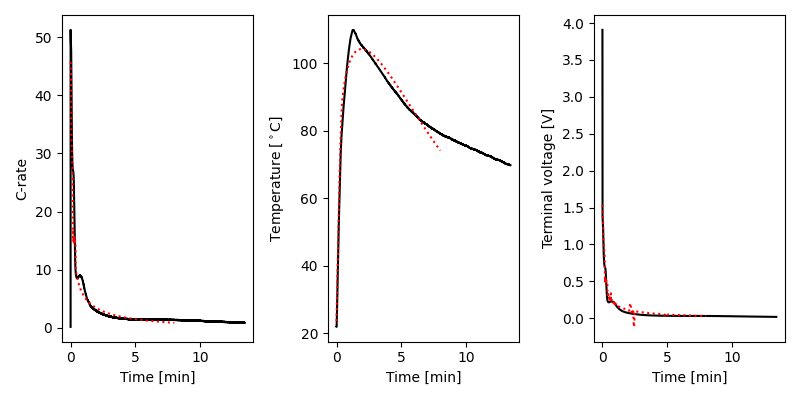

In [8]:
# define sim parameters
SOC_0 = 0.75
# data_current = data[['t','I']].to_numpy()
    
# Fit thermal params
k0 = np.array([2]*2)
lb = np.array([0.5]*2)
ub = np.array([5]*2)
k = dfols.solve(simulate_esc_T, k0, bounds = (lb,ub), rhoend=1e-2)

# simulate with k
solutions = []

# fitted
h = k.x[0]
Cp = k.x[1]
param.update({
    "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
    "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
    "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
    "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
    "Edge heat transfer coefficient [W.m-2.K-1]":h,
    "Total heat transfer coefficient [W.m-2.K-1]":h,
    "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
    "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
    })
solver = pybamm.CasadiSolver(mode="safe",dt_max = 1) #dt_max = 1e-3
sim = pybamm.Simulation(model, parameter_values = param)
solution = sim.solve( initial_soc=SOC_0, t_eval = t_eval)
solutions.append(solution)

# plot with 
plot_data(data,solutions)

In [23]:
k.x

array([0.72753047, 1.51997699])

In [50]:
display([k for k in model.variables.keys()])

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Throughput capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosity',
 'X-averaged separator porosity',
 'X-averaged positive electrode porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Leading-order porosity',
 'Leading-order separator porosity',
 'Leading-order positive electrode porosity',
 'Leading-order x-averaged separator porosity',
 'Leading-order x-averaged positive electrode porosity',
 'Leading-order negative electrode porosity',
 'Leading-order x-averaged negative electrode porosity',
 'Porosity change',
 'Separator porosity change',
 'Positive elect

Some of the output variables are defined over space as well as time. Once option to visualise these variables is to use the `interact` slider widget. Below we plot the negative/positive particle concentration over $r$, using a slider to change the current time point

The QuickPlot class can be used to plot the common set of useful outputs which should give you a good initial overview of the model. The method `Quickplot.dynamic_plot` employs the slider widget.  

interactive(children=(FloatSlider(value=0.0, description='t', max=1170.1690019126265, step=11.701690019126266)…

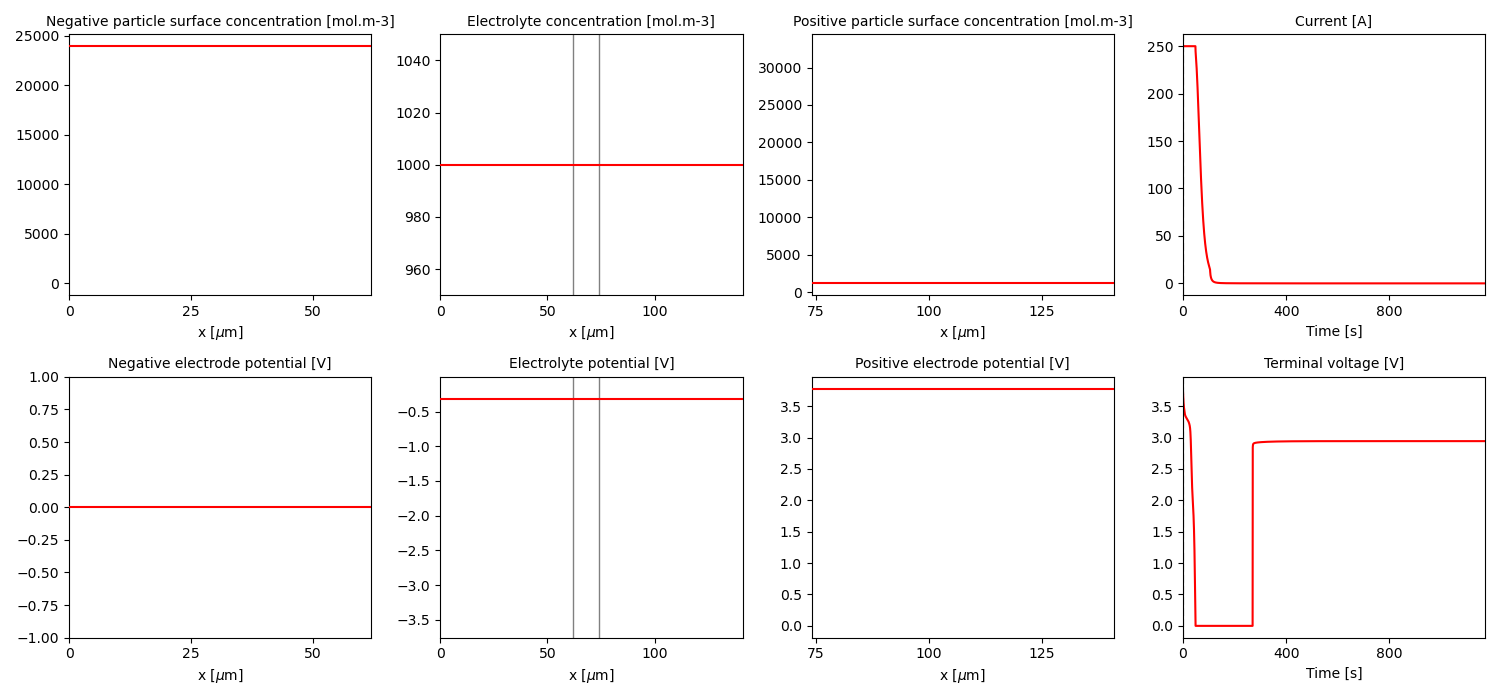

In [51]:
solution = solutions[0]
quick_plot = pybamm.QuickPlot(solution)
quick_plot.dynamic_plot();

## Dimensionless Parameters

In the table below, we provide the dimensionless parameters in the SPM in terms of the dimensional parameters in LCO.csv. We use a superscript * to indicate dimensional quantities. 

| Parameter                 | Expression                              |Interpretation                             |
|:--------------------------|:----------------------------------------|:------------------------------------------|
| $L_{\text{k}}$            | $L_{\text{k}}^*/L^*$                    | Ratio of region thickness to cell thickness|
|$\mathcal{C}_{\text{k}}$   | $\tau_{\text{k}}^*/\tau_{\text{d}}^*$   | Ratio of solid diffusion and discharge timescales |
|$\mathcal{C}_{\text{r,k}}$ |$\tau_{\text{r,k}}^*/\tau_{\text{d}}^*$  |Ratio of reaction and discharge timescales|
|$a_{R, \text{k}}$             |$a_{\text{k}}^* R_{\text{k}}^*$          | Product of particle radius and surface area to volume ratio|
|$\gamma_{\text{k}}$        |$c_{\text{k,max}}^*/c_{\text{n,max}}^*$  |Ratio of maximum lithium concentrations in solid|

In [52]:
c_s_n = solution['Negative particle concentration']
c_s_p = solution['Positive particle concentration']
r_n = solution["r_n [m]"].entries[:, 0, 0]
r_p = solution["r_p [m]"].entries[:, 0, 0]

def plot_concentrations(t):
    f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,5))
    plot_c_n, = ax1.plot(r_n, c_s_n(r=r_n,t=t,x=x[0]))  # can evaluate at arbitrary x (single representative particle)
    plot_c_p, = ax2.plot(r_p, c_s_p(r=r_p,t=t,x=x[-1]))  # can evaluate at arbitrary x (single representative particle)
    ax1.set_ylabel('Negative particle concentration')
    ax2.set_ylabel('Positive particle concentration')
    ax1.set_xlabel(r'$r_n$ [m]')
    ax2.set_xlabel(r'$r_p$ [m]')
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    plt.show()
    
import ipywidgets as widgets
widgets.interact(plot_concentrations, t=widgets.FloatSlider(min=0,max=3600,step=10,value=0));


interactive(children=(FloatSlider(value=0.0, description='t', max=3600.0, step=10.0), Output()), _dom_classes=…

## References

The relevant papers for this notebook are:

In [53]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(782